# Grid setup

## Imports

In [320]:
%load_ext autoreload
%autoreload 2

# 3rd party imports
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from pprint import pprint
from tqdm import tqdm
import networkx as nx

# Local imports
import modules.laplacian as laplacian
import modules.jacobian as jacobian
import modules.correspondences as correspondences

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Functions

In [368]:
def get_neighborhood(point, points, max_dist):
    # Get the Euclidean distance between the point and all other points
    distances = np.linalg.norm(points - point, axis=1)
    
    # Get the indices of the points within the neighborhood
    neighborhood_indices = np.where(distances <= max_dist)[0]
    
    # Get the points within the neighborhood
    neighborhood = points[neighborhood_indices]
    
    #neighborhood = [pt for pt in neighborhood if pt != point]
    
    return neighborhood_indices, neighborhood


def get_magnitude(v):
    return np.linalg.norm(v)


def angle_between_vectors(v1, v2):
    # arccos (A dot B / |A||B|)
    # Compute the dot product
    dot_product = np.dot(v1, v2)
    
    # Compute the magnitudes of the vectors
    magnitude_v1 = np.linalg.norm(v1)
    magnitude_v2 = np.linalg.norm(v2)
    
    if magnitude_v1 == 0 or magnitude_v2 == 0:
        return 0, 0
    
    # Compute the cosine of the angle
    cos_theta = dot_product / (magnitude_v1 * magnitude_v2)
    
    # Clip the cosine value to the range [-1, 1] to avoid numerical issues
    cos_theta = np.clip(cos_theta, -1.0, 1.0)
    
    # Compute the angle in radians
    angle_rad = np.arccos(cos_theta)
    
    # Convert the angle to degrees
    angle_deg = np.degrees(angle_rad)
    
    return angle_rad, angle_deg

m1 = np.array([0, 1, 0])
f1 = np.array([0, 1, 4])

m2 = np.array([0, 3, 0])
f2 = np.array([0, 4, 4])

# Example vectors
# v1 = np.array([1, 0, 0])
# v2 = np.array([1, 0.5, 0])

v1 = f1 - m1
v2 = f2 - m2

# Compute the angle between the vectors
angle_rad, angle_deg = angle_between_vectors(v1, v2)

# Check if the angle exceeds a certain threshold (e.g., 45 degrees)
threshold_deg = 45
if angle_deg > threshold_deg:
    print(f"The vectors differ by a lot: {angle_deg:.2f} degrees")
else:
    print(f"The vectors do not differ by a lot: {angle_deg:.2f} degrees")
    
    
def get_negative_jdet_coordinates(jdet_field: np.ndarray) -> np.ndarray:
    """
    Get the coordinates of the negative values in the Jacobian determinant field.
    
    Parameters
    ----------
    jdet_field : np.ndarray
        The Jacobian determinant field.
    
    Returns
    -------
    np.ndarray
        The coordinates of the negative values
    """
    # Get the indices of the negative values
    indices = np.where(jdet_field <= 0)
    
    # Get the coordinates of the negative values
    coordinates = np.column_stack((indices[0], indices[1]))
    
    return coordinates

The vectors do not differ by a lot: 14.04 degrees


## Load data

Correspondence point shape: (1246, 3)

First five fixed points:
 [[  0.  10. 175.]
 [  0.  10. 174.]
 [  0.  10. 176.]
 [  0.  10. 181.]
 [  0.  10. 188.]]
First five moving points:
 [[  0.  17. 179.]
 [  0.  18. 172.]
 [  0.  18. 180.]
 [  0.  15. 187.]
 [  0.  15. 188.]]
First five correspondence vectors:
 [[ 0. -7. -4.]
 [ 0. -8.  2.]
 [ 0. -8. -4.]
 [ 0. -5. -6.]
 [ 0. -5.  0.]]

Number of negative or zero Jacobian determinants: 168
Number of negative or zero Jacobian determinants: 168
Minimum Jacobian determinant: -4.141267670622895



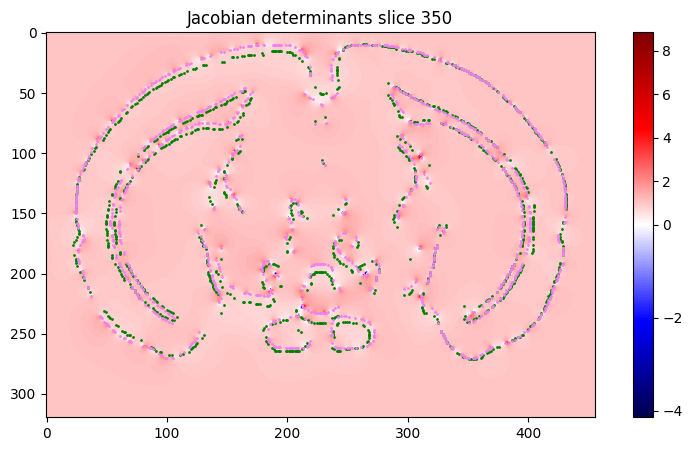

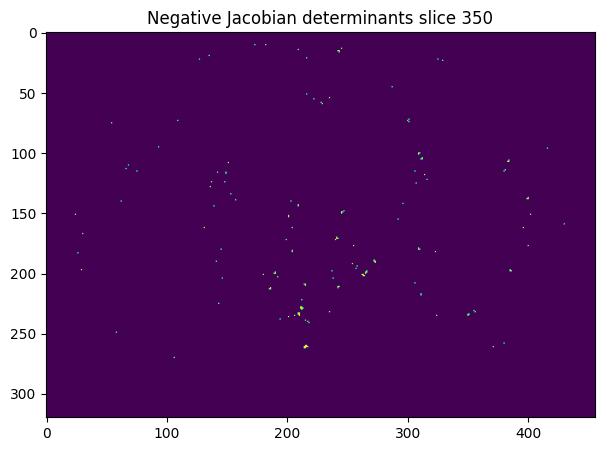

In [322]:
CURR_IDX = 350  # Only consider the correspondences of this index

# Input parameters
base_path = "data/corrected_correspondences_count_touching/registered_output/deformation3d.npy"
mpoints_path = "data/corrected_correspondences_count_touching/mpoints.npy"
fpoints_path = "data/corrected_correspondences_count_touching/fpoints.npy"

# Load the numpy array and compute the jacobian determinant
mpoints = np.load(mpoints_path)
fpoints = np.load(fpoints_path)

# Get only elements that are of the current index
mpoints = mpoints[mpoints[:, 0] == CURR_IDX]
fpoints = fpoints[fpoints[:, 0] == CURR_IDX]

# Change the 0th index in each element to 0
mpoints[:, 0] = 0
fpoints[:, 0] = 0

cvectors = fpoints - mpoints  # Correspondence vectors

print("Correspondence point shape:", fpoints.shape)
print("\nFirst five fixed points:\n", fpoints[:5])
print("First five moving points:\n", mpoints[:5])
print("First five correspondence vectors:\n", cvectors[:5])

# Get Jacobian determinant field
fixed_resolution = np.zeros((1, 320, 456))
deformation, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_resolution, mpoints, fpoints)
jdet_field = jacobian.sitk_jacobian_determinant(deformation)[0]
negative_jdet_field = jdet_field <= 0
negative_jdet_field = negative_jdet_field.astype(bool)
norm = mcolors.TwoSlopeNorm(vmin=min(jdet_field.min(), -1), vcenter=0, vmax=jdet_field.max())

# Print the number of negative or zero Jacobian determinants
print("\nNumber of negative or zero Jacobian determinants:", np.sum(jdet_field <= 0))
print("Number of negative or zero Jacobian determinants:", np.sum(negative_jdet_field))
print("Minimum Jacobian determinant:", jdet_field.min())
print()

# Plot the Jacobian determinant values
f = plt.figure(figsize=(10, 5))
plt.imshow(jdet_field, cmap="seismic", norm=norm)
plt.colorbar()
plt.scatter(mpoints[:, 2], mpoints[:, 1], c="g", s=1)
plt.scatter(fpoints[:, 2], fpoints[:, 1], c="violet", s=1)
plt.title(f"Jacobian determinants slice {CURR_IDX}")
plt.show()
f.clear()
plt.close(f)

# Plot the negative Jacobian determinants
f = plt.figure(figsize=(10, 5))
plt.imshow(negative_jdet_field, cmap='viridis')
plt.title(f"Negative Jacobian determinants slice {CURR_IDX}")
plt.show()
f.clear()
plt.close(f)

In [398]:
def create_grid(jdet_field: np.ndarray, fpoints: np.ndarray, mpoints: np.ndarray):
    """
    Creates a full grid of correspondence information.
    
    Parameters:
    jdet_field (np.ndarray): The Jacobian determinant field.
    fpoints (np.ndarray): The fixed points.
    mpoints (np.ndarray): The moving points.
    
    Returns:
    np.ndarray: The grid of points. Each element contains the following information:
        - y (int): The y-coordinate of the point.
        - x (int): The x-coordinate of the point.
        - theta (float): The angle of the vector relative to the x-axis.
        - magnitude (float): The magnitude
        If there is no correspondence, the element is None.
    """
    # Initialize the grid as an object array
    #dtype = [('y', np.int32), ('x', np.int32), ('theta', np.float32), ('magnitude', np.float32)]
    grid = np.empty(jdet_field.shape, dtype=object)
    
    # Store all information about correspondences into the grid
    for i in range(len(fpoints)):
        curr_fpt = fpoints[i].astype(int)
        curr_mpt = mpoints[i].astype(int)
        curr_vector = curr_fpt - curr_mpt
        
        # Get current correspondence information
        _, y, x = curr_fpt                                  # Coordinate location
        theta = np.arctan2(curr_vector[2], curr_vector[1])  # Angle of the vector relative to the x-axis
        if theta < 0:
            theta += 2 * np.pi
        magnitude = np.linalg.norm(curr_vector)             # Magnitude of the vector
        
        # Place these values into the grid
        grid[y, x] = (y, x, theta, magnitude)
        
    return grid
        
        
def local_grid(coord: tuple, grid: np.ndarray, jdet_field: np.ndarray, n: int=11):
    """
    Get the n x n grid of points around the coordinate.
    
    Parameters:
    coord (tuple): The coordinate of the point.
    grid (np.ndarray): The grid of points.
    n (int): The size of the grid.
    
    Returns:
    np.ndarray: The n x n grid of points around the coordinate.
    """
    # Get the n x n points around the coordinate
    if len(coord) == 2:
        y, x = coord
    else:
        z, y, x = coord
    y_min = max(y - (n // 2), 0)
    y_max = min(y + (n // 2) + 1, grid.shape[0])
    x_min = max(x - (n // 2), 0)
    x_max = min(x + (n // 2) + 1, grid.shape[1])
    
    return grid[y_min:y_max, x_min:x_max], jdet_field[y_min:y_max, x_min:x_max]


def show_grid(grid: np.ndarray, jdet_field: np.ndarray, fontsize=6, title=None):
    """
    Show the grid of points.
    
    Parameters:
    grid (np.ndarray): The grid of points.
    jdet_field (np.ndarray): The Jacobian determinant field.
    """
    # Create a colormap for the Jacobian determinant field
    norm = mcolors.TwoSlopeNorm(vmin=min(jdet_field.min(), -1), vcenter=0, vmax=jdet_field.max())
    magnitude_scale = 0.33  # To scale the vector magnitude for visualization purposes
    
    # Initialize the figure
    f = plt.figure(figsize=(20, 10))
    plt.imshow(jdet_field, cmap="seismic", norm=norm)
    plt.colorbar()
    
    # Write coordinates on the plot
    for j in range(grid.shape[0]):
        for i in range(grid.shape[1]):
            if grid[j, i] is not None:
                y, x, theta, magnitude = grid[j, i]
                degrees = np.degrees(theta)
                
                # Write coordinate text
                coord_text = f"({y}, {x})\n\n"
                vector_text = f"\n{degrees:.2f}°\n" + f"{magnitude:.2f}"
                jdet_text = f"[{jdet_field[j, i]:.2f}]"
                pixel_text = coord_text + jdet_text + vector_text
                plt.text(i, j, pixel_text, color="black", ha='center', va='center', fontsize=fontsize, weight='bold')
                #plt.text(i, j, coord_text, color="black", ha='center', va='bottom', fontsize=fontsize, weight='bold')   # Coordinate
                #plt.text(i, j, vector_text, color="black", ha='center', va='top', fontsize=fontsize, weight='bold')     # Vector info
                #plt.text(i, j, jdet_text, color="black", ha='center', va='center', fontsize=fontsize, weight='normal')  # Jdet
                plt.arrow(i, j, np.cos(theta) * magnitude_scale, np.sin(theta) * magnitude_scale, head_width=0.15, head_length=0.15, fc='green', ec='green')
    
    # Set the title and show the plot
    if title is None:
        plt.title(f"Neighborhood grid {grid.shape[0]} x {grid.shape[1]}")
    else:
        plt.title(title)
    plt.show()
    f.clear()
    plt.close(f)
    
    
def get_neighbors(grid: np.ndarray):
    """
    Get the neighbors of the central point in the grid.
    
    Parameters:
    grid (np.ndarray): The grid of points.
    
    Returns:
    np.ndarray: The neighbors in the grid.
    """
    # Initialize the neighbors array
    neighbors = []
    
    # Central coordinate
    central_y = grid.shape[0] // 2
    central_x = grid.shape[1] // 2
    
    # Iterate through each point in the grid
    for j in range(grid.shape[0]):
        for i in range(grid.shape[1]):
            is_central = (j == central_y and i == central_x)
            if grid[j, i] is not None and not is_central:  # Avoid returning central point as neighbor
                # Store the neighborhood in the neighbors array
                neighbors.append(grid[j, i])
    return neighbors


def get_central_point(grid: np.ndarray):
    """
    Get the central point in the grid.
    
    Parameters:
    grid (np.ndarray): The grid of points.
    
    Returns:
    tuple: The central point.
    """
    # Central coordinate
    central_y = grid.shape[0] // 2
    central_x = grid.shape[1] // 2
    
    return grid[central_y, central_x]

# Setup grid

In [416]:
# Print some sample negative Jdet coordinates for use
neg_coordinates = get_negative_jdet_coordinates(jdet_field)
print("Negative Jacobian determinant coordinates:")
pprint(neg_coordinates[-25:])

Negative Jacobian determinant coordinates:
array([[234, 209],
       [234, 210],
       [234, 350],
       [234, 351],
       [235, 206],
       [235, 210],
       [235, 324],
       [235, 350],
       [236, 201],
       [238, 194],
       [239, 215],
       [240, 217],
       [241, 218],
       [249,  58],
       [258, 380],
       [260, 215],
       [260, 216],
       [261, 214],
       [261, 215],
       [261, 216],
       [261, 217],
       [261, 371],
       [262, 214],
       [262, 215],
       [270, 106]])


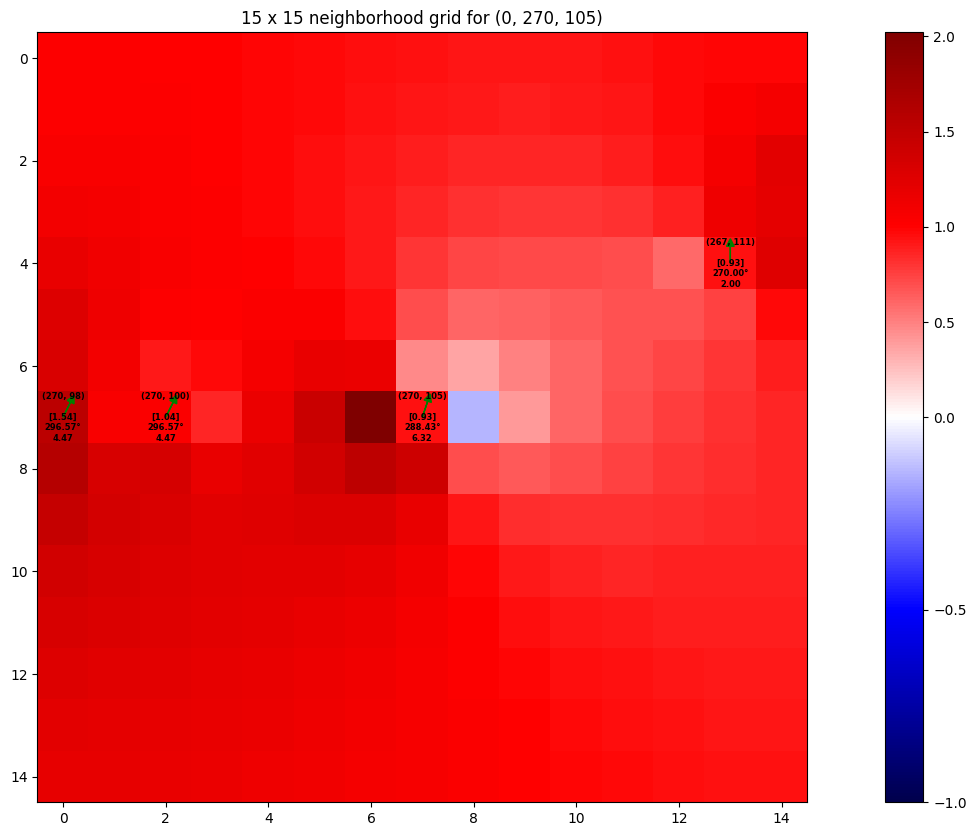

In [418]:
# Input parameters
curr_coord = (0, 270, 105) # (0, 10, 175)
n = 15

# Populate the grid with the correspondence information
full_grid = create_grid(jdet_field, fpoints, mpoints)

# Get a local grid sample
curr_grid, curr_jdet_field = local_grid(curr_coord, full_grid, jdet_field, n=n)
show_grid(curr_grid, curr_jdet_field, title=f"{n} x {n} neighborhood grid for {curr_coord}")

## Set up scoring for current grid

In [419]:
weight_magnitude = 0.5  # 0.8
weight_theta = 0.5  # 0.2

# Get the neighbors and central point
neighbors = get_neighbors(curr_grid)
central_point = get_central_point(curr_grid)

# Get the central point information
central_y, central_x, central_theta, central_magnitude = central_point


# Get the normalized magnitudes and angles of the neighbors
neighbor_info = []
for neighbor in neighbors:
    y, x, theta, magnitude = neighbor
    distance = np.linalg.norm(np.array([y, x]) - np.array([central_y, central_x]))
    normalized_theta = abs(theta - central_theta)
    normalized_magnitude = magnitude / central_magnitude
    neighbor_info.append((distance, normalized_theta, normalized_magnitude))    

# Get neighbor metrics
neighbor_distances = np.array([neighbor[0] for neighbor in neighbor_info])
neighbor_thetas = np.array([neighbor[1] for neighbor in neighbor_info])
neighbor_magnitudes = np.array([neighbor[2] for neighbor in neighbor_info])


# Compute score between central point and neighbors
CURR_NEIGHBOR_IDX = 0

curr_neighbor = neighbor_info[CURR_NEIGHBOR_IDX]
curr_neighbor_distance, curr_neighbor_theta, curr_neighbor_magnitude = curr_neighbor

# Compute the penalties for distance
max_distance = np.sqrt((curr_grid.shape[0]/2)**2 + (curr_grid.shape[1]/2)**2)
# max_distance = np.max(neighbor_distances)
distance_weight = (max_distance - curr_neighbor_distance) / max_distance
distance_weight = 1

# Compute the penalties for theta
theta_penalty = curr_neighbor_theta / np.pi

# Compute the penalties for magnitude
magnitude_variance = np.var(neighbor_magnitudes)
max_difference = np.max(neighbor_magnitudes)
scaling_factor = 2.0  # Influences local variance on penalty for magnitude differences
magnitude_penalty = abs(curr_neighbor_magnitude - 1) * (1 + scaling_factor * magnitude_variance)

# Compute the score
score = 1 - distance_weight * (weight_theta * theta_penalty + weight_magnitude * magnitude_penalty)


print("Current point:", central_point)
print("Current neighbor index:", CURR_NEIGHBOR_IDX)
print("\nNeighbors:")
pprint(neighbors)

print("\nNeighbor information [distance, normalized theta, normalized magnitude]:")
pprint(neighbor_info)

print("\nCurrent neighbor:")
print("\tDistance:", curr_neighbor_distance, "Theta:", curr_neighbor_theta, "Magnitude:", curr_neighbor_magnitude)
print("Score:", score)
print("\tDistance penalty:", distance_weight)
print("\tTheta penalty:", theta_penalty)
print("\tMagnitude penalty:", magnitude_penalty)

Current point: (270, 105, 5.034139534781332, 6.324555320336759)
Current neighbor index: 0

Neighbors:
[(267, 111, 4.71238898038469, 2.0),
 (270, 98, 5.176036589385496, 4.47213595499958),
 (270, 100, 5.176036589385496, 4.47213595499958)]

Neighbor information [distance, normalized theta, normalized magnitude]:
[(6.708203932499369, 0.32175055439664213, 0.31622776601683794),
 (7.0, 0.14189705460416402, 0.7071067811865475),
 (5.0, 0.14189705460416402, 0.7071067811865475)]

Current neighbor:
	Distance: 6.708203932499369 Theta: 0.32175055439664213 Magnitude: 0.31622776601683794
Score: 0.5836898915831359
	Distance penalty: 1
	Theta penalty: 0.10241638234956671
	Magnitude penalty: 0.7302038344841615


## Run scoring on all neighbors

In [422]:
consensus_thresh = 0.5

consensus = []
# Compute score between central point and ALL neighbors
for i in range(len(neighbor_info)):
    CURR_NEIGHBOR_IDX = i
    curr_neighbor = neighbor_info[CURR_NEIGHBOR_IDX]
    curr_neighbor_distance, curr_neighbor_theta, curr_neighbor_magnitude = curr_neighbor

    # Compute the penalties for distance
    max_distance = np.sqrt((curr_grid.shape[0]/2)**2 + (curr_grid.shape[1]/2)**2)
    # max_distance = np.max(neighbor_distances)
    distance_weight = (max_distance - curr_neighbor_distance) / max_distance
    distance_weight = 1

    # Compute the penalties for theta
    theta_penalty = curr_neighbor_theta / np.pi

    # Compute the penalties for magnitude
    magnitude_variance = np.var(neighbor_magnitudes)
    max_difference = np.max(neighbor_magnitudes)
    scaling_factor = 2.0  # Influences local variance on penalty for magnitude differences
    magnitude_penalty = abs(curr_neighbor_magnitude - 1) * (1 + scaling_factor * magnitude_variance)

    # Compute the score
    score = 1 - distance_weight * (weight_theta * theta_penalty + weight_magnitude * magnitude_penalty)
    if score >= consensus_thresh:
        consensus.append(1)
    else:
        consensus.append(0)

    #print("Current point:", central_point)
    #print("Current neighbor index:", CURR_NEIGHBOR_IDX)
    #print("\nNeighbors:")
    #pprint(neighbors)

    #print("\nNeighbor information [distance, normalized theta, normalized magnitude]:")
    #pprint(neighbor_info)

    print(f"\n({neighbors[i][0]}, {neighbors[i][1]})")
    print("Score:", score)
    #print("\tDistance penalty:", distance_weight)
    print("\tTheta penalty:", theta_penalty)
    print("\tMagnitude penalty:", magnitude_penalty)

print("\nConsensus:", f"{np.sum(consensus)}/{len(consensus)}", "positive.")
if np.sum(consensus) >= len(consensus) / 2:
    print("Correspondence is labeled \'good\'.")
else:
    print("Correspondence is labeled \'bad\'.")


(267, 111)
Score: 0.5836898915831359
	Theta penalty: 0.10241638234956671
	Magnitude penalty: 0.7302038344841615

(270, 98)
Score: 0.8210253058750734
	Theta penalty: 0.04516723530086658
	Magnitude penalty: 0.31278215294898654

(270, 100)
Score: 0.8210253058750734
	Theta penalty: 0.04516723530086658
	Magnitude penalty: 0.31278215294898654

Consensus: 3/3 positive.
Correspondence is labeled 'good'.
